# Loading in the training data names and all the masks


In [6]:
import numpy as np
import random
import sklearn
import pandas as pd
from skimage.io import imread
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import seaborn as sns
dsb_data_dir = os.path.join('.', 'input')
stage_label = 'stage1'

#Make plots inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#Autoreload external python modules
%load_ext autoreload
%autoreload 2

#Loading method from https://www.kaggle.com/kmader/nuclei-overview-to-submission/notebook
train_labels = pd.read_csv(os.path.join(dsb_data_dir,'{}_train_labels.csv'.format(stage_label)))
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,ImageId,EncodedPixels
22987,c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf...,"[223973, 4, 224491, 8, 225011, 9, 225529, 12, ..."
12373,62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa7...,"[266605, 9, 267120, 16, 267636, 21, 268154, 24..."
24697,d1ba6089cae2f90cb7275ece10ca393c25f60ea17e5c9c...,"[92, 7, 348, 7, 604, 7, 861, 7, 1117, 7, 1374,..."


In [7]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_test = lambda in_path: in_path.split('\\')[0]
img_id = lambda in_path: in_path.split('\\')[-3]
img_type = lambda in_path: in_path.split('\\')[-2]
img_group = lambda in_path: in_path.split('\\')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('\\')[-4].split('_')[0]

img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)

,path,ImageId,ImageType,TrainingSplit,Stage
10679,.\input\stage1_train\547ef286ee5f4e5dce533e982...,547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3c...,masks,train,stage1
21534,.\input\stage1_train\af8621ef0db8c26b0bce6385b...,af8621ef0db8c26b0bce6385bd5609b584bfd678fcf7a2...,masks,train,stage1


In [8]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

Wall time: 56.9 s


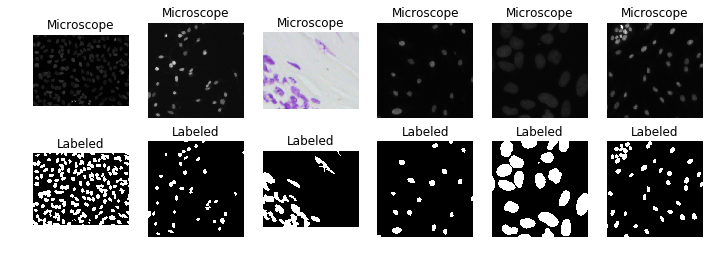

In [9]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

In [10]:
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []

group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
test_img_df.sample(1)

,ImageId,Stage,images
63,fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e...,stage1,"[[[0.0627450980392, 0.0627450980392, 0.0627450..."


(6, 3)


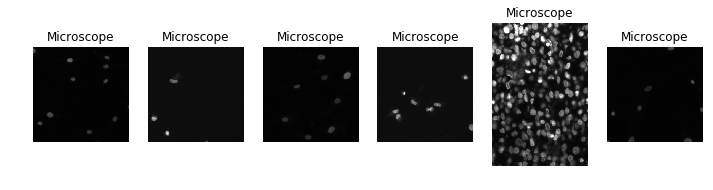

In [11]:
n_img = 6

fig, m_axs = plt.subplots(1, n_img, figsize = (12,4))
print(test_img_df.sample(n_img).shape)

for (_, c_row),(c_im) in zip(test_img_df.sample(n_img).iterrows(),m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis("off")
    c_im.set_title('Microscope')
    

Text(0.5,0,'Pixel Intensity')

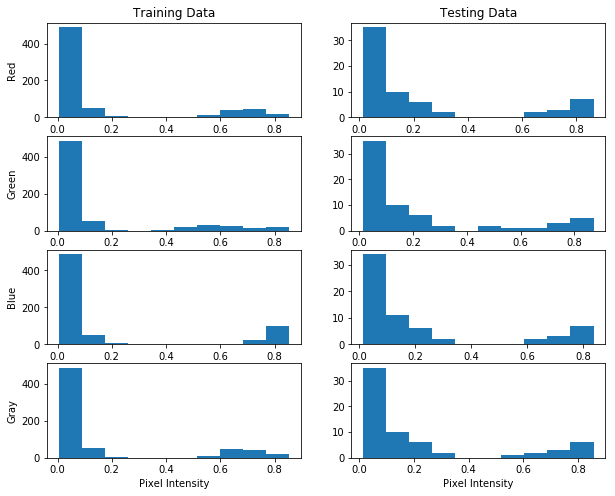

In [12]:
train_img_df['Red'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,0]))
train_img_df['Green'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,1]))
train_img_df['Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,2]))
train_img_df['Gray'] = train_img_df['images'].map(lambda x: np.mean(x))
train_img_df['Std'] = train_img_df['images'].map(lambda x: np.std(x))

test_img_df['Red'] = test_img_df['images'].map(lambda x: np.mean(x[:,:,0]))
test_img_df['Green'] = test_img_df['images'].map(lambda x: np.mean(x[:,:,1]))
test_img_df['Blue'] = test_img_df['images'].map(lambda x: np.mean(x[:,:,2]))
test_img_df['Gray'] = test_img_df['images'].map(lambda x: np.mean(x))
test_img_df['Std'] = test_img_df['images'].map(lambda x: np.std(x))

plt.figure(1)
plt.subplot(4,2,1)
plt.hist(train_img_df['Red'])
plt.title('Training Data') 
plt.ylabel('Red')

plt.subplot(4,2,2)
plt.hist(test_img_df['Red'])
plt.title('Testing Data')

plt.subplot(4,2,3)
plt.hist(train_img_df['Green'])
plt.ylabel('Green')

plt.subplot(4,2,4)
plt.hist(test_img_df['Green'])

plt.subplot(4,2,5)
plt.hist(train_img_df['Blue'])
plt.ylabel('Blue')

plt.subplot(4,2,6)
plt.hist(test_img_df['Blue'])

plt.subplot(4,2,7)
plt.hist(train_img_df['Gray'])
plt.ylabel('Gray')
plt.xlabel('Pixel Intensity')

plt.subplot(4,2,8)
plt.hist(test_img_df['Gray'])
plt.xlabel('Pixel Intensity')


Text(0,0.5,'Pixel Intensity')

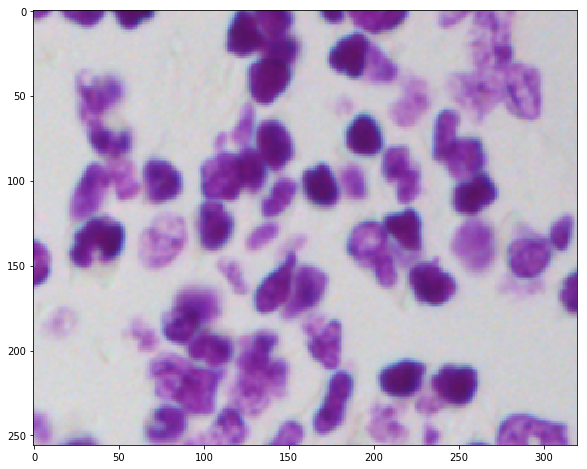

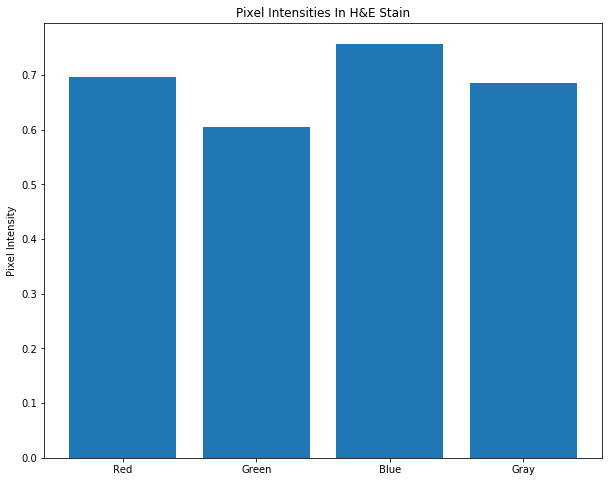

In [27]:
#Picking out a specific image to look at the color intensities of the image
#Looking at a H&E stain
selected_image = train_img_df.query('ImageId=="00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e"')
bar_graph_selected_image = (selected_image['Red'].values,selected_image['Green'].values,
                            selected_image['Blue'].values,selected_image['Gray'].values)
bar_graph_selected_image = np.concatenate(bar_graph_selected_image)
ind = np.arange(4)
plt.figure()
plt.imshow(selected_image['images'].values[0])

plt.figure()
plt.bar(ind,bar_graph_selected_image)
plt.title('Pixel Intensities In H&E Stain')
plt.xticks(ind, ('Red', 'Green', 'Blue', 'Gray'))
plt.ylabel('Pixel Intensity')
#test_img_df.query('')



Text(0,0.5,'Pixel Intensity')

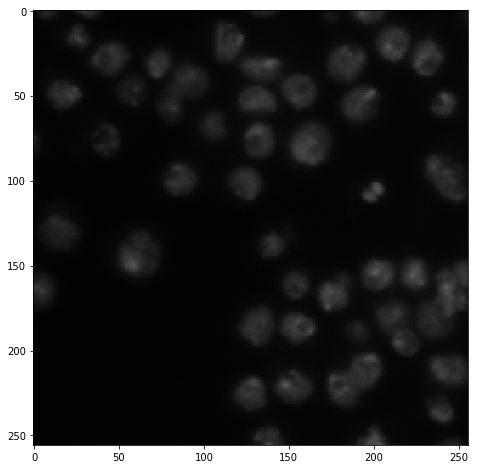

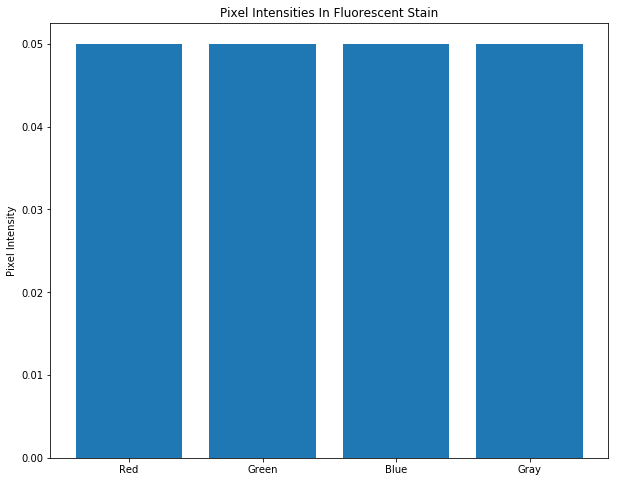

In [29]:
#Looking at fluorescent stain
selected_image = train_img_df.query('ImageId=="0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0"')
bar_graph_selected_image = (selected_image['Red'].values,selected_image['Green'].values,
                            selected_image['Blue'].values,selected_image['Gray'].values)
bar_graph_selected_image = np.concatenate(bar_graph_selected_image)
ind = np.arange(4)
plt.figure()
plt.imshow(selected_image['images'].values[0])

plt.figure()
plt.bar(ind,bar_graph_selected_image)
plt.title('Pixel Intensities In Fluorescent Stain')
plt.xticks(ind, ('Red', 'Green', 'Blue', 'Gray'))
plt.ylabel('Pixel Intensity')

Text(0,0.5,'Pixel Intensity')

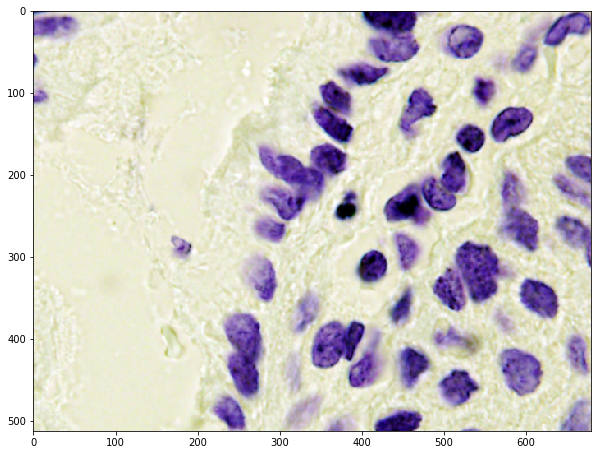

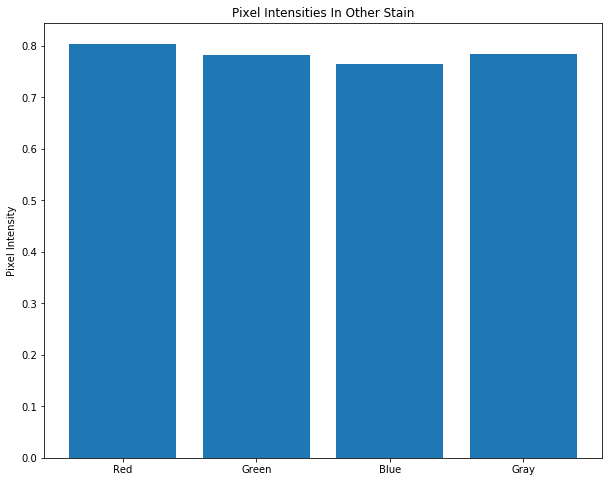

In [30]:
#Looking at other staining in testing data
selected_image = test_img_df.query('ImageId=="44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078"')
bar_graph_selected_image = (selected_image['Red'].values,selected_image['Green'].values,
                            selected_image['Blue'].values,selected_image['Gray'].values)
bar_graph_selected_image = np.concatenate(bar_graph_selected_image)
ind = np.arange(4)
plt.figure()
plt.imshow(selected_image['images'].values[0])

plt.figure()
plt.bar(ind,bar_graph_selected_image)
plt.title('Pixel Intensities In Other Stain')
plt.xticks(ind, ('Red', 'Green', 'Blue', 'Gray'))
plt.ylabel('Pixel Intensity')

Text(0,0.5,'Pixel Intensity')

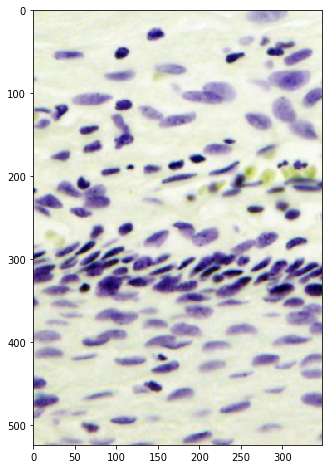

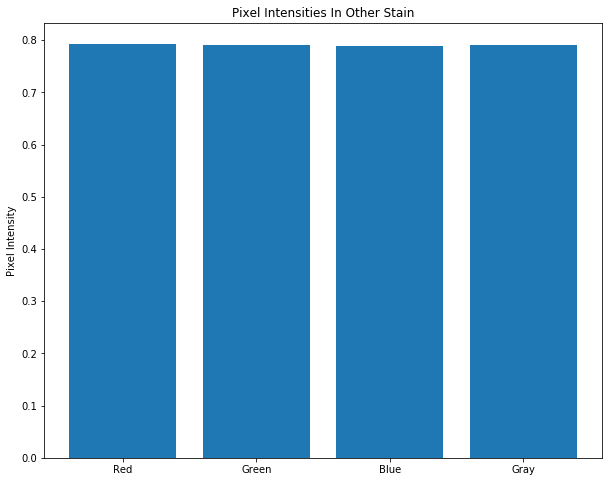

In [32]:
#Looking at other staining in testing data
selected_image = test_img_df.query('ImageId=="3c4c675825f7509877bc10497f498c9a2e3433bf922bd870914a2eb21a54fd26"')
bar_graph_selected_image = (selected_image['Red'].values,selected_image['Green'].values,
                            selected_image['Blue'].values,selected_image['Gray'].values)
bar_graph_selected_image = np.concatenate(bar_graph_selected_image)
ind = np.arange(4)
plt.figure()
plt.imshow(selected_image['images'].values[0])

plt.figure()
plt.bar(ind,bar_graph_selected_image)
plt.title('Pixel Intensities In Other Stain')
plt.xticks(ind, ('Red', 'Green', 'Blue', 'Gray'))
plt.ylabel('Pixel Intensity')